In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import math
from tensorflow import keras
import math
import scipy
state=72
import warnings
warnings.filterwarnings("ignore")
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn
import pandas as pd

import logging

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

df = pd.read_csv("heart.csv")

In [2]:
df.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [3]:
exp = 'nombre_exp_05_07_2021' # set a name of the experiment, in a cicd world

Text(0.5, 1.0, 'Number of People by Sex')

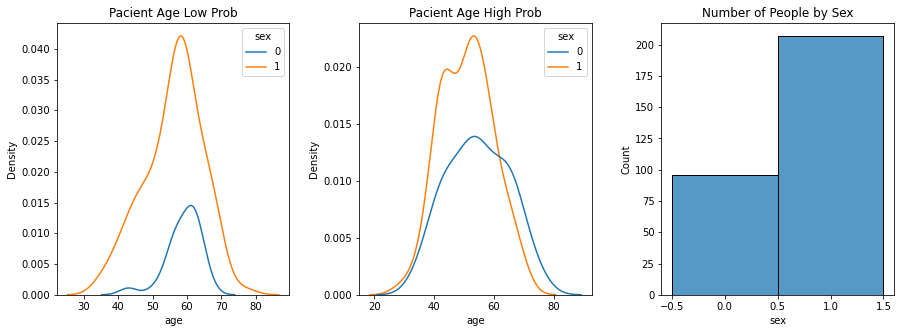

In [4]:
fig, axes = plt.subplots(1,3, figsize = (15,5))
plt.subplots_adjust(wspace=0.3)


plot1 = sns.kdeplot(data = df.loc[df["output"]==0], x = "age",hue="sex", ax = axes [0])
plot1.set_title ("Pacient Age Low Prob")

plot2 = sns.kdeplot(data = df.loc[df["output"]==1], x = "age", hue="sex", ax = axes[1])
plot2.set_title ("Pacient Age High Prob")

plot3 = sns.histplot (data = df, x="sex",stat="count",ax=axes[2], discrete = True)
plot3.set_title ("Number of People by Sex")

In [5]:
print("Median Age for Patients with Lower Heart Attack Probability: {0:0.2f}".format(df.loc[df["output"]==0]["age"].median()))
print("Median Age for Patients with Higher Heart Attack Probability: {0:0.2f}\n\n".format(df.loc[df["output"]==1]["age"].median()))

Median Age for Patients with Lower Heart Attack Probability: 58.00
Median Age for Patients with Higher Heart Attack Probability: 52.00




Average Chest Pain for Patients with Low Probability of Heart Attack: 0.48
Average Chest Pain for Patients with High Probability of Heart Attack: 1.38




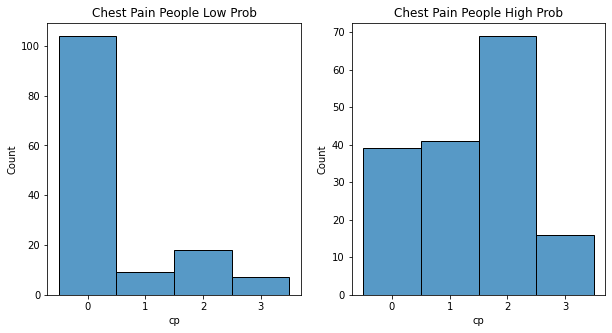

In [6]:
fig, axes = plt.subplots(1,2, figsize = (10,5))
plot1 = sns.histplot(data = df.loc[df["output"]==0], x = "cp", discrete = True, ax = axes[0])
plot1.set_title("Chest Pain People Low Prob")
plot2 = sns.histplot(data = df.loc[df["output"]==1], x = "cp", discrete = True, ax = axes[1])
plot2.set_title("Chest Pain People High Prob")
print("Average Chest Pain for Patients with Low Probability of Heart Attack: {0:0.2f}".format(df.loc[df["output"]==0]["cp"].mean()))
print("Average Chest Pain for Patients with High Probability of Heart Attack: {0:0.2f}\n\n".format(df.loc[df["output"]==1]["cp"].mean()))

Average Heart Rate High Prob. Heart Attack: 158.47
Average Heart Rate Low Prob Heart Attack: 139.10



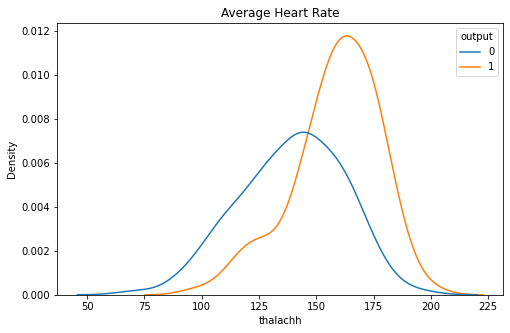

In [7]:
fig, axes = plt.subplots(figsize = (8,5))
plot1 = sns.kdeplot(data = df, x = "thalachh", hue = "output")
plot1.set_title("Average Heart Rate")
print("Average Heart Rate High Prob. Heart Attack: {0:0.2f}\nAverage Heart Rate Low Prob Heart Attack: {1:0.2f}\n".format(df.loc[df["output"]==1]["thalachh"].mean(),df.loc[df["output"]==0]["thalachh"].mean()))

In [8]:
corr_data = df.corr()
print(corr_data["output"].sort_values(ascending=False)[1:4])
print(corr_data["output"].sort_values(ascending=True)[:3])
corr_data.style.background_gradient(cmap='coolwarm', axis=None).set_precision(6)

cp          0.433798
thalachh    0.421741
slp         0.345877
Name: output, dtype: float64
exng      -0.436757
oldpeak   -0.430696
caa       -0.391724
Name: output, dtype: float64


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


In [9]:
X_columns = df.columns.tolist()
X_columns = X_columns[:-1]
Y_columns = "output"

X = df[X_columns]
Y = df[Y_columns]
std_scaler = preprocessing.StandardScaler()

X_scaled = pd.DataFrame(std_scaler.fit_transform(X), columns = X_columns)
pca = decomposition.PCA(n_components = 10)
principalComponents = pca.fit_transform(X_scaled)
df_principal = pd.DataFrame(data = principalComponents
             , columns = ["PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10"])
print("Total Variance of Principal Components: {0}".format(pca.explained_variance_ratio_.sum()))


Total Variance of Principal Components: 0.8980686249325275


In [10]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_scaled, Y, test_size=0.3, random_state=state)

In [11]:
rand_list = {"C": scipy.stats.uniform(2, 30)}

In [12]:
clf = sklearn.linear_model.LogisticRegression (penalty = "l1",solver="saga", random_state=state)
rand_search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, cv = 3, scoring = "f1", random_state=state) 
rand_search.fit(X_train, Y_train) 
print(rand_search.best_params_)

{'C': 22.53027899836062}


In [13]:
# to initialize the experiment to being record in mlflow
with mlflow.start_run(run_name=exp):
    pd.DataFrame(rand_search.cv_results_).head(5)
    C = rand_search.best_params_.get("C",20)
    model = sklearn.linear_model.LogisticRegression (penalty = "l2",solver="saga", C = C, random_state=state)
    mlflow.log_param("penalty", "l2")
    mlflow.log_param("solver", "saga")
    mlflow.log_param("C", C)
    model.fit(X_train, Y_train)
    print("\nF1 Score: {0:0.2f}\n".format(sklearn.metrics.f1_score(Y_test,model.predict(X_test))))
    mlflow.log_metric("F1",sklearn.metrics.f1_score(Y_test,model.predict(X_test)))
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        # this brings the capacity to generate an artifact of your experiment
        mlflow.sklearn.log_model(model, "model", registered_model_name="LogisticRegression")
    else:
        mlflow.sklearn.log_model(model, "model")


F1 Score: 0.88



              precision    recall  f1-score   support

           0       0.81      0.89      0.85        38
           1       0.92      0.85      0.88        53

    accuracy                           0.87        91
   macro avg       0.86      0.87      0.87        91
weighted avg       0.87      0.87      0.87        91



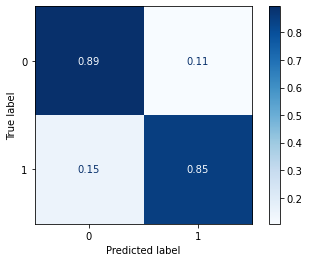

In [14]:
print(sklearn.metrics.classification_report (Y_test, model.predict(X_test)))
sklearn.metrics.plot_confusion_matrix(model, X_test, Y_test, cmap = plt.cm.Blues, normalize = "true")

Feature: age - 0.0182
Feature: sex - -0.7409
Feature: cp - 0.7763
Feature: trtbps - -0.3837
Feature: chol - -0.2900
Feature: fbs - -0.1719
Feature: restecg - 0.1910
Feature: thalachh - 0.4587
Feature: exng - -0.3886
Feature: oldpeak - -0.6307
Feature: slp - 0.4431
Feature: caa - -0.4980
Feature: thall - -0.5645


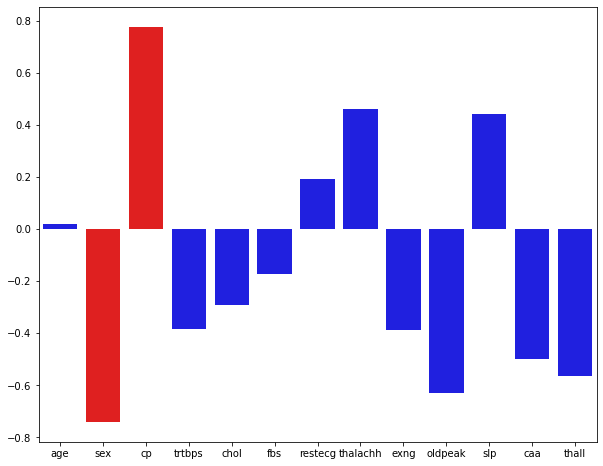

In [15]:
fig, axes = plt.subplots(1, figsize = (10,8))
for i in range(0,13):
    print("Feature: {0} - {1:0.4f}".format(X_scaled.columns.tolist()[i],model.coef_[0][i]))
plot1 = sns.barplot(x = X_train.columns.tolist(),y = model.coef_[0], palette=['red' if (x > 0.7 or x < -0.7) else 'blue' for x in model.coef_[0]], ax = axes)

In [16]:
from sklearn import ensemble
with mlflow.start_run(run_name=exp):
    rand_list = {
                "max_depth":[None,1,2],
                "min_samples_split":[2,3,4]}

    clf = ensemble.RandomForestClassifier(random_state=state)
    rand_search = sklearn.model_selection.RandomizedSearchCV(clf, param_distributions = rand_list, n_iter = 20, cv = 3, scoring = "f1",return_train_score=True, error_score = "raise", random_state=state) 
    rand_search.fit(X_train, Y_train) 
    print(rand_search.best_params_)

    mlflow.log_param("max_depth", rand_search.best_params_.get("max_depth"))
    mlflow.log_param("min_samples_split", rand_search.best_params_.get("min_samples_split"))

    pd.DataFrame(rand_search.cv_results_).head(5)

    model2 = ensemble.RandomForestClassifier(max_depth = rand_search.best_params_.get("max_depth"), min_samples_split = rand_search.best_params_.get("min_samples_split"), random_state=state)
    model2.fit(X_train,Y_train)
    print("\nF1 Score: {0:0.2f}\n".format(sklearn.metrics.f1_score(Y_test,model2.predict(X_test))))
    print(sklearn.metrics.classification_report (Y_test, model2.predict(X_test)))
    mlflow.log_metric("F1",sklearn.metrics.f1_score(Y_test,model2.predict(X_test)))
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(model2, "model", registered_model_name="RandomForestClassifier")
    else:
        mlflow.sklearn.log_model(model2, "model")
    


{'min_samples_split': 2, 'max_depth': 1}

F1 Score: 0.90

              precision    recall  f1-score   support

           0       0.89      0.82      0.85        38
           1       0.88      0.92      0.90        53

    accuracy                           0.88        91
   macro avg       0.88      0.87      0.87        91
weighted avg       0.88      0.88      0.88        91

